# This file brings new insights into current trends regarding localities, topics and events.

# 1. important!: open neo4j, gather required libraries

In [1]:
import os
import csv
from neo4j import GraphDatabase, basic_auth

import matplotlib.pyplot as plt

#currently neo4j is running on localhost
neo4jUrl = os.environ.get('NEO4J_URL',"bolt://192.168.99.100")
neo4jUser = os.environ.get('NEO4J_USER',"neo4j")
neo4jPass = os.environ.get('NEO4J_PASSWORD',"1")

driver = GraphDatabase.driver(neo4jUrl, auth=basic_auth(neo4jUser, neo4jPass))

graph = driver.session()

# 2. prepare parameters for Cypher-queries.
* The desired time periods aggregation can be set with the variable "selectedAggregation".
    - 0 stands for the date; 
    - 1 stands for the month;
    - 2 stands for the week;
    - 3 stands for the hour of a day
* The desired number of top values to be returned can be specified with the variable "numberOfReturnValues". 
    - e.g. value 5 for the top five results

In [2]:
# 0 = date; 1=month; 2=week; 3=clock
dateAggregationOptions = ["date(datetime({epochmillis:toInt(e.time)}))", "date.truncate('month',datetime({epochmillis:toInt(e.time)}))", "date.truncate('week',datetime({epochmillis:toInt(e.time)}), {dayOfWeek:2})" , "time.truncate('hour',(datetime({epochmillis:toInt(e.time)})))"]
selectedAggregation = 1
dateAggregation = dateAggregationOptions[selectedAggregation]
numberOfReturnValues = "8"



# 3. prepare function for printing pie charts.

In [3]:
def printPieChart(date2,data, chartLabels):
    dateAggregationOptionsForChartTitle = ["", "month", "week of", "hour"]
    dateAggregationForChartTitle = dateAggregationOptionsForChartTitle[selectedAggregation]
    
    from datetime import date
    from datetime import datetime
    
    
    if (selectedAggregation == 0):
        date2 = datetime.strptime(str(date2),'%Y-%m-%d').strftime('%A %d %B %Y')
    if (selectedAggregation == 1):
        date2 = datetime.strptime(str(date2),'%Y-%m-%d').strftime('%B %Y')
    if (selectedAggregation == 2):
        dayOfWeek = datetime.strptime(str(date2),'%Y-%m-%d').strftime('%d %B %Y')
        week = datetime.strptime(str(date2),'%Y-%m-%d').strftime('%W')
        date2 = str(dayOfWeek)+" (Week: "+str(week)+")"
    if (selectedAggregation == 3):
        date2 = datetime.strptime(str(date2),'%H:%M:%S.%f000').strftime('%H')

 
    plt.suptitle('Aggregated to the '+dateAggregationForChartTitle+" "+ str(date2) +" (Top: "+numberOfReturnValues+")", fontsize=16)
    labels = chartLabels
    sizes = data
    patches, l, texts = plt.pie(sizes, shadow=True, startangle=90, autopct='%0.1f%%')
    plt.legend(patches,labels, bbox_to_anchor=(1,0.5), loc="center left", fontsize=10, 
           bbox_transform=plt.gcf().transFigure)
    plt.axis('equal')
    plt.show()    
    
    

# top events: Ranking of events based on the number of people who have rsvp'd to these events.
Cell is executed according to the settings in step 2.

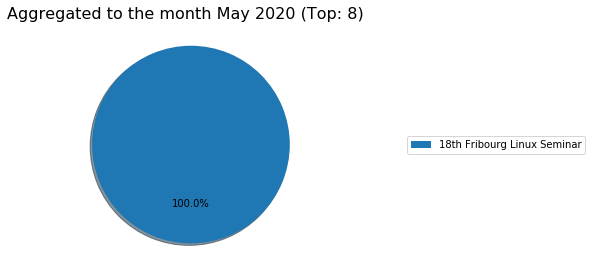

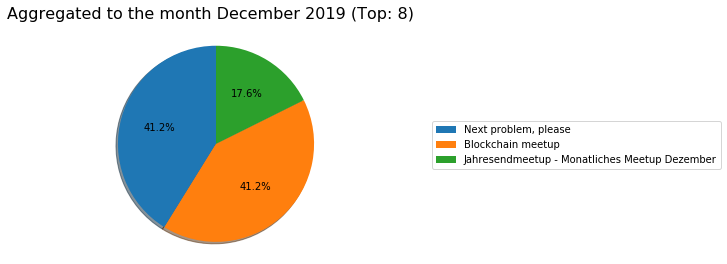

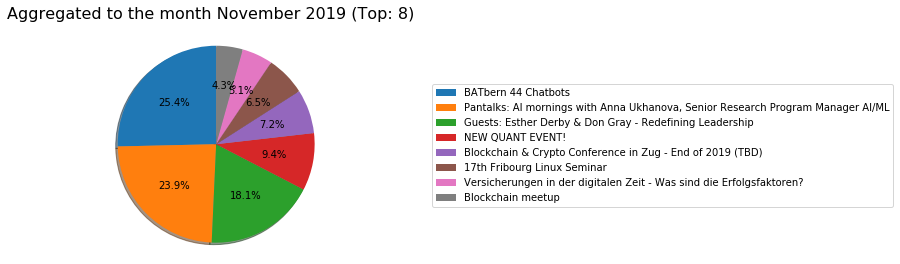

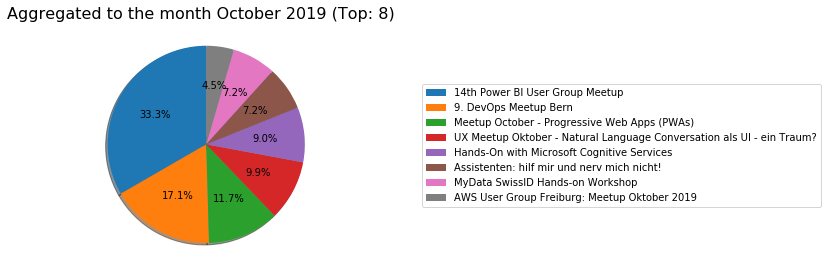

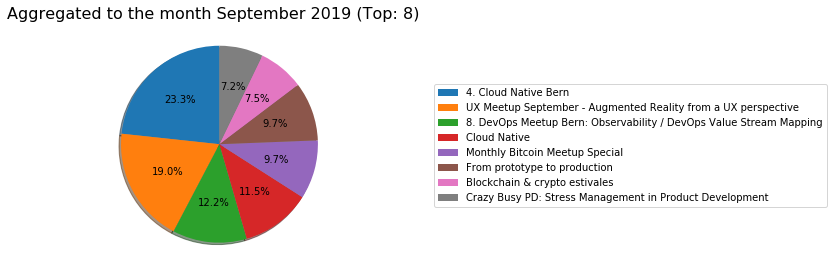

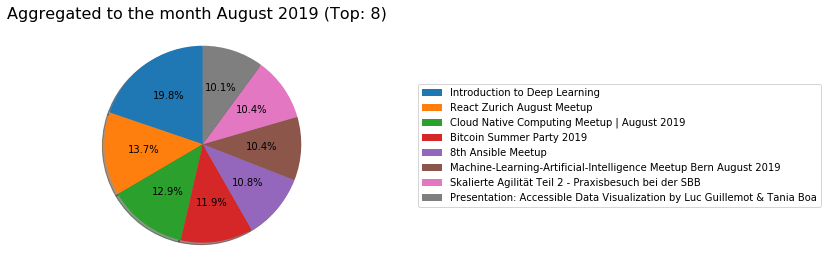

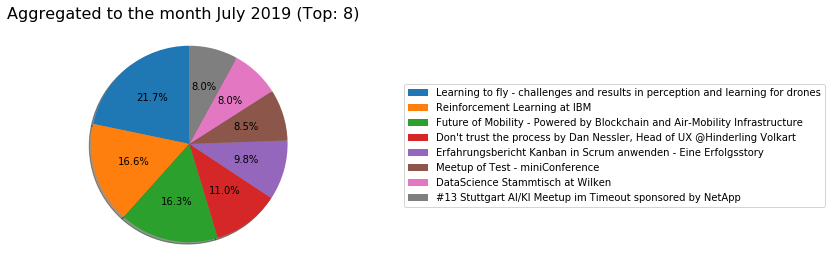

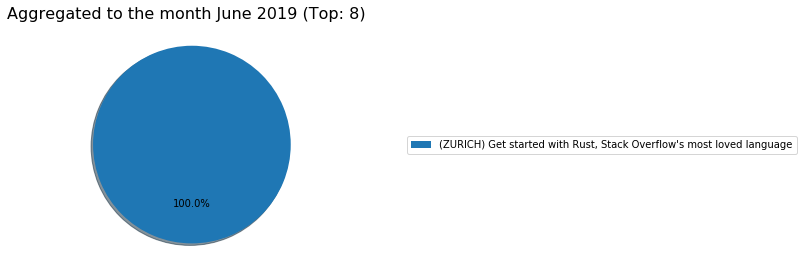

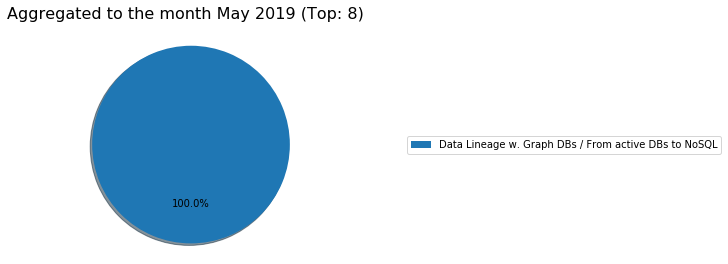

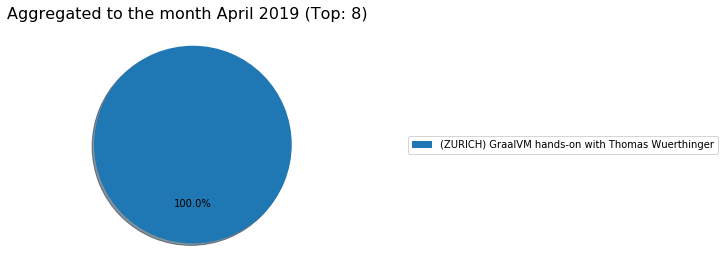

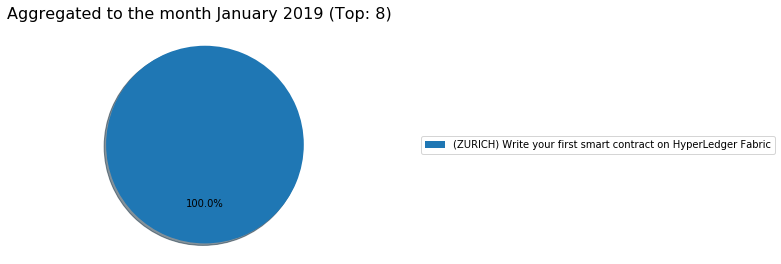

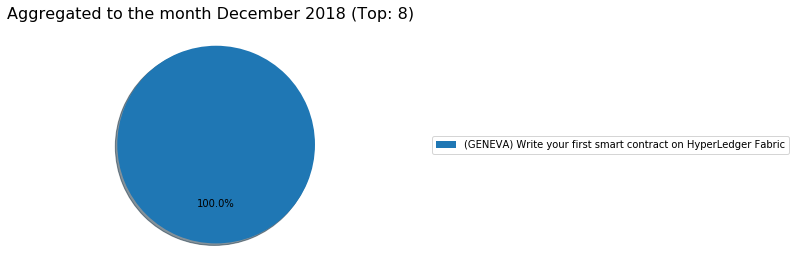

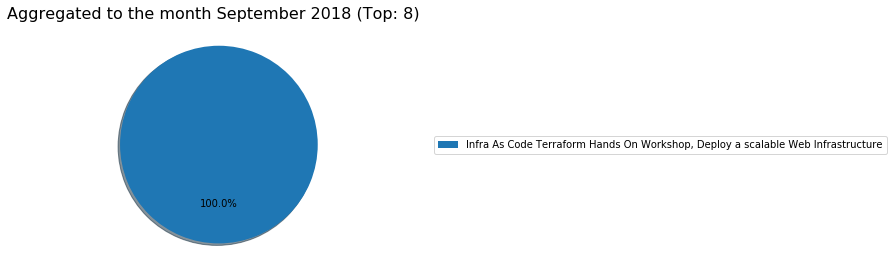

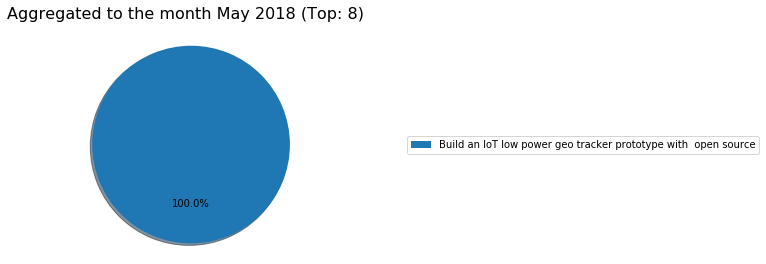

In [4]:
def get_top_events(tx):
    for record in tx.run("match (e:Event)<-[r:RSVPd]-(p:Person) with "+dateAggregation+" as date, count(r) as rsvp_count, e.name as name  order by rsvp_count desc return date, collect(rsvp_count)[.."+numberOfReturnValues+"] as rsvp_number, collect(name)[.."+numberOfReturnValues+"] as event_name order by date desc"):
    
        rsvpcount_events = list(zip(record['rsvp_number'], record['event_name']))
        
        printPieChart(record["date"],record['rsvp_number'],record['event_name'])
                
with driver.session() as session:
    session.read_transaction(get_top_events)
    


# top topics: Ranking of topics based on the number of events about these topics.
Cell is executed according to the settings in step 2.

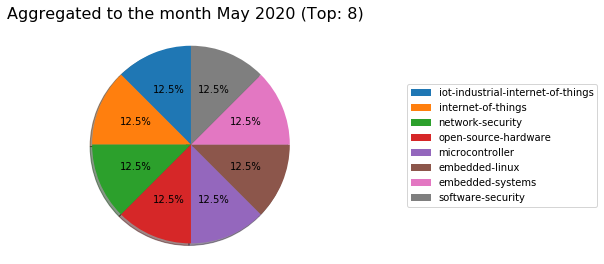

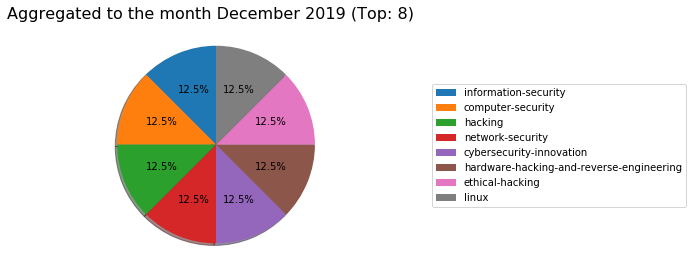

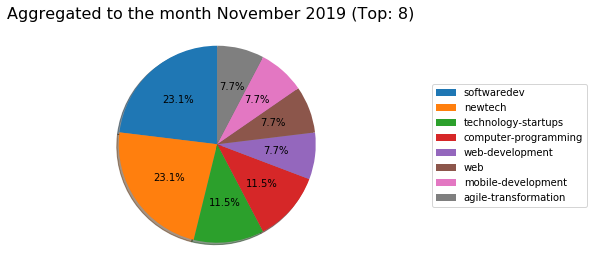

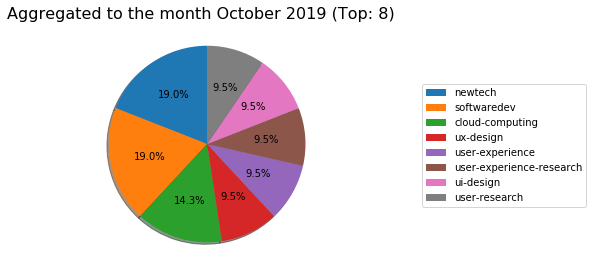

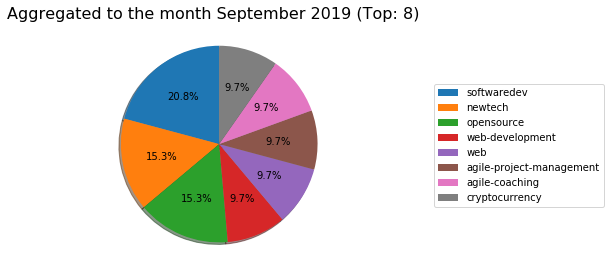

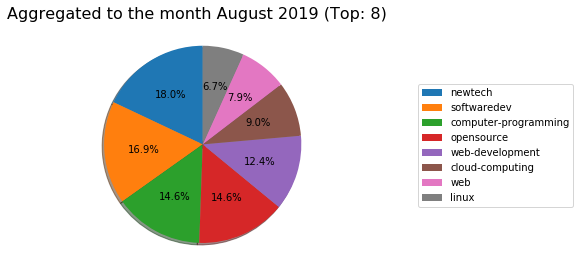

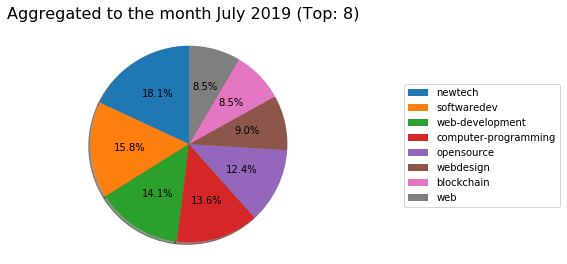

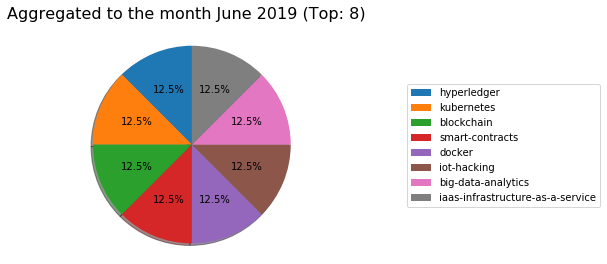

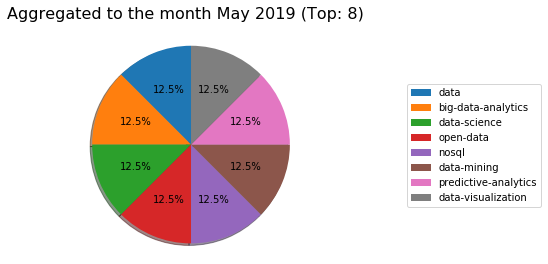

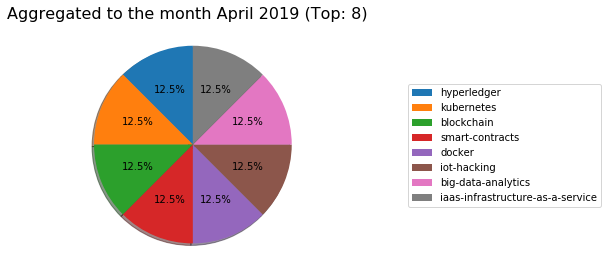

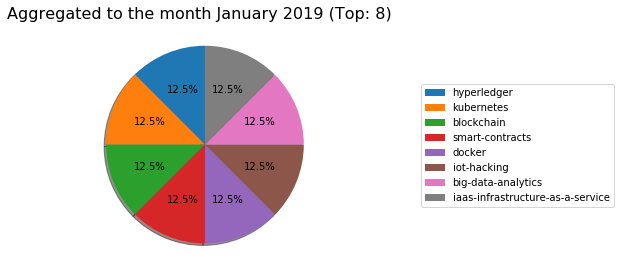

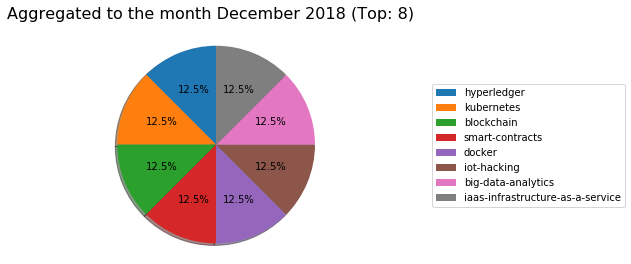

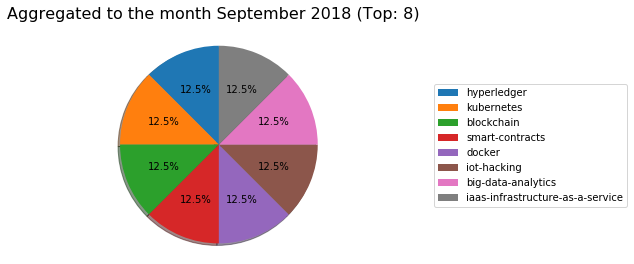

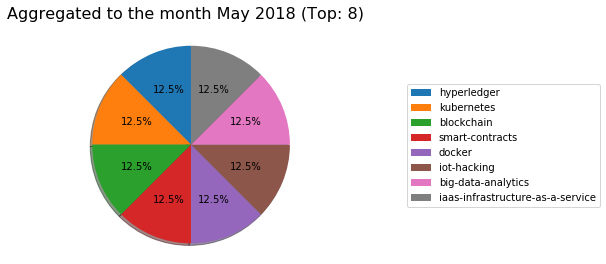

In [5]:
def get_hot_topics(tx):
    for record in tx.run("match(e:Event)<-[:ORGANIZES]-(g:Group)-[:IS_ABOUT]->(t:Topic) with "+dateAggregation+" as date, t.urlkey as topic, count(e) as number_events_per_topic order by number_events_per_topic desc return date, collect(number_events_per_topic)[.."+numberOfReturnValues+"] as events_number, collect(topic)[.."+numberOfReturnValues+"] as topic order by date desc"):
        events_per_topics = list(zip(record['events_number'], record['topic']))

        printPieChart(record["date"],record['events_number'],record['topic'])

with driver.session() as session:
    session.read_transaction(get_hot_topics)

# top locations

# important!: This cell must be executed before the location analysis.
* Configurations for the analysis are made here.
    - If "latLonRoundedToDecimalPlace10" is set to true, the results will be aggregated to the city by rounding longitudes and latitudes to ten decimal places. 
    - If "latLonRoundedToDecimalPlace10" is set to false, the results will be aggregated to the city.

In [8]:
latLonRoundedToDecimalPlace10 = True
if latLonRoundedToDecimalPlace10 == True:
    latLon = "round(toFloat(v.lat)*10)/10 as lat, round(toFloat(v.lon)*10)/10 as lon"
else:
    latLon = "toFloat(v.lat) as lat, toFloat(v.lon) as lon"

# top locations: Ranking of the locations based on the number of events which take place in these locations.
- The map information is fetched using "openstreetmap" with the given longitudes and latitutdes.
- (Cell is executed according to the settings in step 2 and the location aggregation settings from the above cell.)

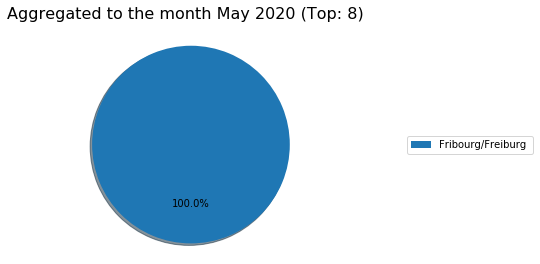

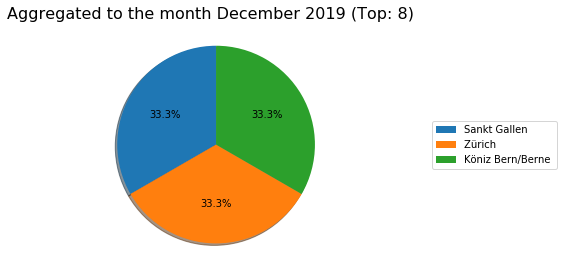

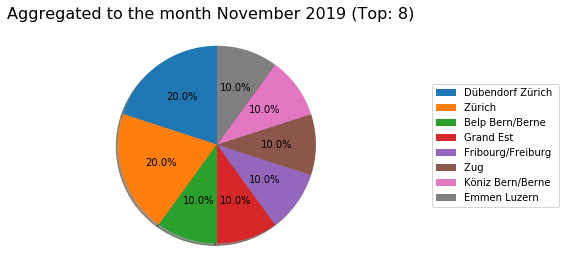

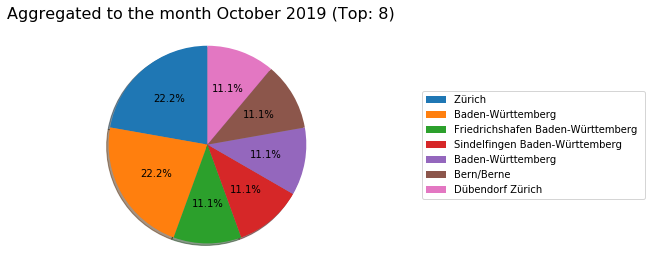

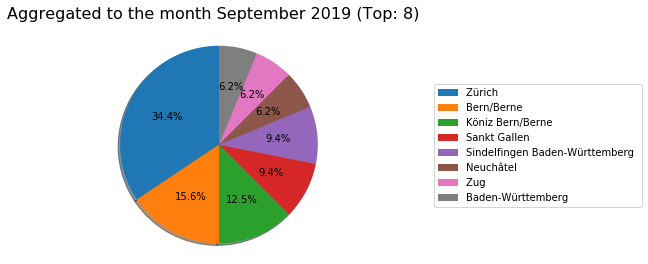

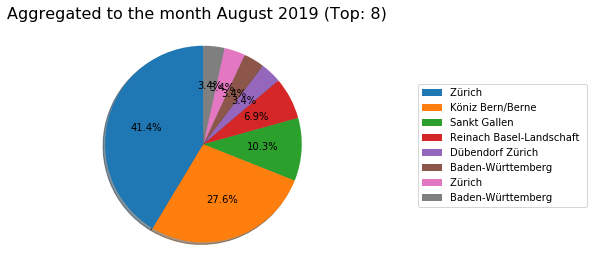

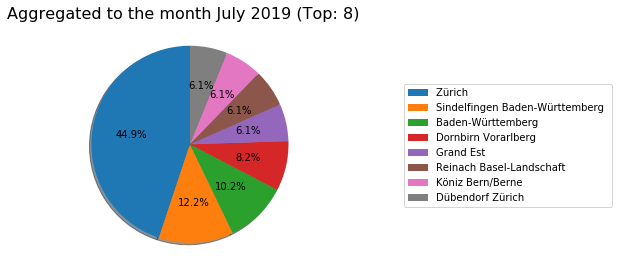

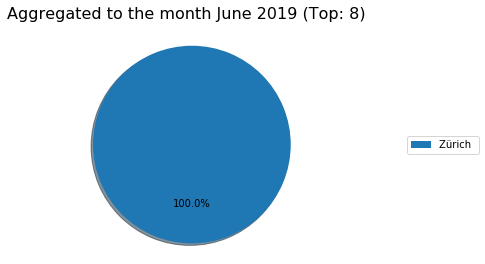

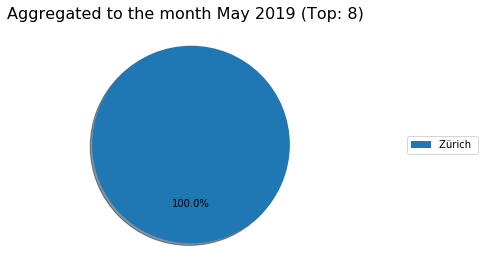

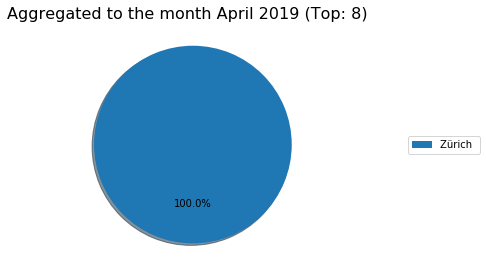

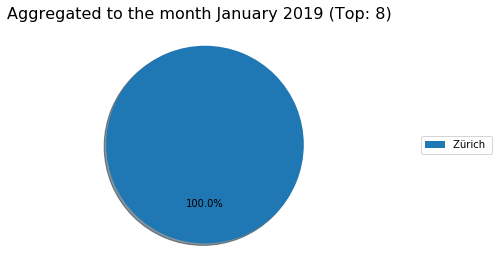

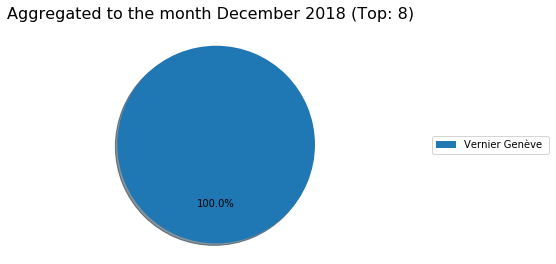

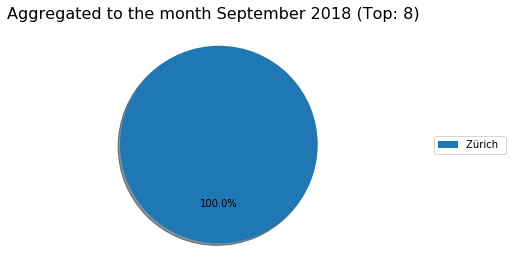

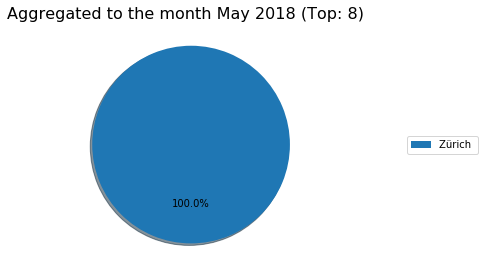

In [9]:

from geopy.geocoders import Nominatim
def get_hot_locations(tx):
    for record in tx.run("match(e:Event)-[:TAKES_PLACE_AT]->(v:Venue) where not v.address = '' and  not v.city=''  with "+dateAggregation+" as date, "+latLon+", count(*) as number_events_at_location order by  number_events_at_location desc  return date, collect(number_events_at_location)[.."+numberOfReturnValues+"] as events_number, collect(lon)[.."+numberOfReturnValues+"] as lon, collect(lat)[.."+numberOfReturnValues+"]  as lat order by date desc "):
        
        geolocator = Nominatim(user_agent="specify_your_app_name_here")

        addresses = []
        
        for lat, lon in zip(record['lat'], record['lon']):
            location = geolocator.reverse([lat,lon], timeout=10, addressdetails=True)
            address = location.raw['address']
            
            road = ""
            state =""
            town=""
            house_number=""
            postcode = ""
            footway = ""
            
            if (latLonRoundedToDecimalPlace10 == False):
                if 'road' in address:
                    road =  address['road']
                    road += " "
                if 'house_number' in address:
                    house_number = address['house_number']
                    house_number += ", "
                if 'footway' in address:
                    footway = address['footway']
                    footway += ", "
                if 'postcode' in address:
                    postcode = address['postcode']
                    postcode += " "
            if 'state' in address:
                state = address['state']
                state += " "
            if 'town' in address:
                town = address['town']
                town += " "
      
            addresses.append(footway+road+house_number+postcode+town+state)


        
        printPieChart(record["date"],record['events_number'],addresses)

    
with driver.session() as session:
    session.read_transaction(get_hot_locations)

# close neo4j connection

In [ ]:
graph.close()